In [1]:
from mnist_gan.mnistGan import MnistGan
from mnist_cnn.mnistCnn import MnistCnn
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.nn import conv2d

In [2]:
cnn = MnistCnn()
cnn.loadWeights('mnist_cnn/largerCnn30Epochs')
#cnn.model.summary()

#load gan
genPath = 'mnist_gan/NewMnistGan200Epochs/mnist_gen'
discPath = 'mnist_gan/NewMnistGan200Epochs/mnist_disc'
gan = MnistGan()
gan.loadWeights(genPath, discPath)

(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255 #pixel values in [0,1]
print(img_data.shape)
test_data = x_test.copy()
test_data = test_data.reshape(x_test.shape[0], 28, 28, 1)
test_data = test_data / 255
print(test_data.shape)
y_test_one_hot = np.eye(10)[y_test]
#print(y_test_one_hot.shape)
#print(y_test_one_hot[0:2])

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [3]:
test_img = np.expand_dims(img_data[0], 0)
print(test_img.shape)
test_var = tf.Variable(tf.cast(test_img, dtype = tf.float32))
print(test_var.shape)
print(test_var[0,0,0,0])

(1, 28, 28, 1)
(1, 28, 28, 1)
tf.Tensor(0.0, shape=(), dtype=float32)


## Fast Gradient Sign Method
$ || \eta ||_{\infty} \leq \epsilon $:
- $ \eta = \epsilon \cdot \text{sign}( \nabla_x J(\theta, x, y)) $
- perturbs all pixel values equally

$ || \eta ||_{2} \leq ||\epsilon \mathbb{1}_d||_{2} $:
- $ \eta = \epsilon \sqrt{d} \cdot \frac{\nabla_x J(\theta,x,y)}{||\nabla_x J(\theta,x,y)||_2} $
- perturbs values more when their gradient is higher

$ || \eta ||_1 \leq ||\epsilon \mathbb{1}_d||_1 $:
- sort $ \nabla_x J(\theta,x,y) $ by their absolute values $ |\nabla_x J(\theta,x,y)| $
- maximize / minimize pixels with the highest absolute gradient until budget $ \epsilon d $ is depleted

### Increase loss or decrease probability?
**Idea 1:**
- increase the loss (same loss function as used to train the cnn)
- stop when prediction has changed
- optional: decrease the loss with the new prediction until a certain confidence is reached

**Idea 2:**
- decrease the probability of the original prediction
- stop when prediction has changed
- optional: increase the new probability to a certain value

**Idea 3:**
- increase the probability of a class that looks similar to the original prediction to the human eye

**Idea 4:**
- decrease the loss of a class that looks similar to the original to the human eye

**Idea 5:**
- increase the probability of a class that is statistically similar to the original prediction
- confusion matrix could be used to find similar classes

**Idea 6:**
- decrease the loss of a class that is statistically similar

In [4]:
cnnLoss = tf.keras.losses.CategoricalCrossentropy(from_logits = False)

### define target functions:

In [5]:
#loss
@tf.function
def targetFuncLoss(x, index, classifier):
    # compute the loss of the prediction and a unit vector
    unitVector = tf.reshape(tf.one_hot(indices = index, depth = 10), shape = (1,10))
    res = cnnLoss(classifier(x), unitVector)
    return res

# loss + discriminator
@tf.function
def targetFuncLossGan(x, index, classifier):
    unitVector = tf.reshape(tf.one_hot(indices = index, depth = 10), shape = (1,10))
    res = cnnLoss(classifier(x), unitVector) + gan.discriminator(x)
    return res

# negative probability to be minimized
@tf.function
def targetFuncNegativeProb(x, index, classifier):
    # compute the natural logarithm of the predicted probability
    res = -tf.math.log(tf.squeeze(classifier(x))[index])
    return res

# negative prob + discriminator
@tf.function
def targetFuncNegativeProbGan(x, index, classifier):
    res = -tf.math.log(tf.squeeze(classifier(x))[index]) + gan.discriminator(x)
    return res

# positive probability to be maximized
@tf.function
def targetFuncProb(x, index, classifier):
    res = tf.math.log(tf.squeeze(classifier(x))[index])
    return res

# positive prob + discriminator
@tf.function
def targetFuncProbGan(x, index, classifer):
    res = tf.math.log(tf.squeeze(classifier(x))[index]) + gan.discriminator(x)
    return res

### define norm constraints:

In [75]:
# maximum norm
def maxNorm(grad, epsilon):
    res = epsilon * tf.math.sign(grad)
    return res

# euclidean norm
def euclidNorm(grad, epsilon):
    err = 1e-16
    d = 28*28
    norm = tf.norm(grad, ord='euclidean')
    res = epsilon*math.sqrt(d)*(grad/tf.maximum(norm, err))
    return res

In [76]:
#utility function to get row and col from an index
def vecIndexToMatIndex(index, dim):
    row = math.floor(index/dim)
    col = index % dim
    return row, col

# utility function to get a unit matrix
def getUnitMat(dim, row, col):
    # dim: number of rows/columns
    # row: index of row
    # col: index of column
    if(row >= dim):
        raise ValueError("row index out of bounds")
    if(col >= dim):
        raise ValueError("column index out of bounds")
    index = row*(dim) + col
    e = tf.one_hot(indices = index, depth = dim*dim)
    mat = tf.reshape(e, shape = (dim,dim))
    return mat

In [97]:
#test
#testMat = tf.reshape(tf.range(0,16,delta=1), shape=(4,4))
#testVec = tf.range(0,16,delta=1)
unitMat = np.expand_dims(np.expand_dims((10.1 * getUnitMat(4, 3, 0)),1),0)
print(unitMat.shape)
unitMat2 = 2 * getUnitMat(4,3,0)
print(unitMat2)
#print(testVec)

(1, 4, 1, 4)
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [78]:
row, col = vecIndexToMatIndex(index = 10, dim = 4)
print(testMat[row,col].numpy())

10


In [108]:
testImage1724 = tf.cast(np.expand_dims(tf.zeros_like(img_data[0]),0),tf.float32)
print(testImage1724.shape)
testDiff1813 = np.expand_dims(np.expand_dims(getUnitMat(testImage1724.shape[1],0,0),0),3)
print(testDiff1813.shape)
testSum1819 = testImage1724 + testDiff1813
print(testSum1819.shape)
#print(testSum1819)

(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


In [111]:
# 1-norm
# maximize / minimize the pixels with the greatest impact on the prediction
# one step maximally perturbs pixels with the greatest impact with a maximum perturbation of epsilon
def oneNorm(x, grad, epsilon):
    #to do: optimize this code
    d = 28*28
    abs_grad = tf.abs(grad)
    sign_grad = tf.math.sign(grad)
    budget = epsilon * d
    # get indices of grad sorted by greatest abs value as 1xd-vector
    abs_grad_sorted_indices = tf.argsort(tf.reshape(abs_grad, shape = (d,)), direction='DESCENDING')
    # x = x + eta
    eta = tf.zeros_like(grad)
    print(eta.shape)
    for i in range(d):
        index = abs_grad_sorted_indices[i] #start iterating over indices
        row, col = vecIndexToMatIndex(index = index, dim = 28) #corresponding row and column
        diff = sign_grad[0,row,col,0] * tf.abs(x[0,row,col,0] - ((sign_grad[0,row,col,0] / 2) + 0.5)) #get diff to 0 or 1 depending on the sign of the gradient
        if(budget >= tf.abs(diff)):
            #eta[0,row,col,0] += diff
            eta = eta + np.expand_dims(np.expand_dims((diff * getUnitMat(eta.shape[1],row,col)),0),3)
            budget -= tf.abs(diff)
        else:
            #eta[0,row,col,0] += (sign_grad[0,row,col,0] * budget)
            eta = eta + np.expand_dims(np.expand_dims(((sign_grad[0,row,col,0] * budget) * getUnitMat(eta.shape[1],row,col)),0),3)
            budget = 0
        if(budget <= 0):
            break
    
    print(eta.shape)
    x.assign(x + eta)
    #x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))

### define optimization algorithms:

In [81]:
# optimize loss or probability with euclidean norm constraint or maximum norm constraint
def optimizeEuclidOrMaxNorm(x, classifier, maxIter, maxChange, minAlpha, targetFunction, normConstraint, epsilon = 0.1):
    err = 1e-16 #accuracy
    closeEnough = False
    iter = 0 #iteration counter
    index = tf.argmax(tf.squeeze(classifier(x))).numpy() #original prediction
    d = 28*28
    # create the unit vector with a one at index and dim 10
    #unitVector = tf.one_hot(indices = index, depth = 10)
    
    while(not closeEnough and iter < maxIter):
        with tf.GradientTape() as tape:
            res = targetFunction(x, index, classifier)
        grad = tape.gradient(res, x)
        eta = normConstraint(grad, epsilon)
        x.assign(x + eta)
        x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
        iter += 1
        newIndex = tf.argmax(tf.squeeze(classifier(x))).numpy()
        if(newIndex != index):
            closeEnough = True
    return iter

# optimize loss or probability with 1-norm
def optimize1Norm(x, classifier, maxIter, maxChange, minAlpha, targetFunction, epsilon = 0.1):
    err = 1e-16
    closeEnough = False
    iter = 0
    index = tf.argmax(tf.squeeze(classifier(x))).numpy()
    d = 28*28
    
    while(not closeEnough and iter < maxIter):
        with tf.GradientTape() as tape:
            res = targetFunction(x, index, classifier)
        grad = tape.gradient(res, x)
        oneNorm(x, grad, epsilon)
        iter += 1
        newIndex = tf.argmax(tf.squeeze(classifier(x))).numpy()
        if(newIndex != index):
            closeEnough = True
    return iter

### Tests

(1, 28, 28, 1)
(1, 28, 28, 1)


Text(0.5, 1.0, 'oneNorm, class: 8, conf: 0.67874223')

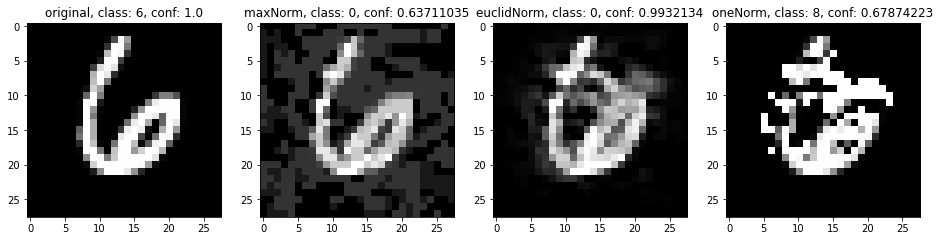

In [112]:
# to do: look at alpha
# test for example image
rs = np.random.RandomState(seed=2)
n_examples = 1
indices = rs.randint(0, img_data.shape[0], n_examples)

img = img_data[indices[0]]

_, ax = plt.subplots(n_examples, 4, figsize=(16,16))

x1 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))
x2 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))
x3 = tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))

optimizeEuclidOrMaxNorm(x1, cnn.model, maxIter=600, maxChange=0.1, minAlpha=0.001, targetFunction=targetFuncLoss, normConstraint=maxNorm, epsilon=0.1)
optimizeEuclidOrMaxNorm(x2, cnn.model, maxIter=600, maxChange=0.1, minAlpha=0.001, targetFunction=targetFuncLoss, normConstraint=euclidNorm, epsilon=0.1)
optimize1Norm(x3, cnn.model, maxIter=600, maxChange=0.1, minAlpha=0.001, targetFunction=targetFuncLoss, epsilon=0.1)

ax[0].imshow(img, cmap = 'gray', interpolation = 'none')
pred0 = tf.squeeze(cnn.model(np.expand_dims(img, 0)))
class0 = tf.argmax(pred0).numpy()
conf0 = tf.reduce_max(pred0).numpy()
title0 = "original, " + "class: " + str(class0) + ", conf: " + str(conf0)
ax[0].set_title(title0)
ax[1].imshow(x1[0], cmap = 'gray', interpolation = 'none')
pred1 = tf.squeeze(cnn.model(x1))
class1 = tf.argmax(pred1).numpy()
conf1 = tf.reduce_max(pred1).numpy()
title1 = "maxNorm, " + "class: " + str(class1) + ", conf: " + str(conf1)
ax[1].set_title(title1)
ax[2].imshow(x2[0], cmap = 'gray', interpolation = 'none')
pred2 = tf.squeeze(cnn.model(x2))
class2 = tf.argmax(pred2).numpy()
conf2 = tf.reduce_max(pred2).numpy()
title2 = "euclidNorm, " + "class: " + str(class2) + ", conf: " + str(conf2)
ax[2].set_title(title2)
ax[3].imshow(x3[0], cmap = 'gray', interpolation = 'none')
pred3 = tf.squeeze(cnn.model(x3))
class3 = tf.argmax(pred3).numpy()
conf3 = tf.reduce_max(pred3).numpy()
title3 = "oneNorm, " + "class: " + str(class3) + ", conf: " + str(conf3)
ax[3].set_title(title3)

In [ ]:
rs = np.random.RandomState(seed=2)
print(rs.randint(0,60000,1))

In [ ]:
unitVector = tf.one_hot(indices = 1, depth = 10)
newUnitVector = tf.reshape(unitVector, shape=[10,1])
print(newUnitVector)
print(newUnitVector.shape)

In [ ]:
print(cnn.model(tf.Variable(tf.cast(np.expand_dims(img,0), tf.float32))).shape)